In [1]:
# Setup scenario
from copy import deepcopy
import json
from pathlib import Path

from constants import DATA_ENTITIES_DIR, DATA_HAZARDS_DIR, DATA_TEMP_DIR, REQUIREMENTS_DIR
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from climada.engine import CostBenefit, Impact, ImpactCalc
from climada.engine.cost_benefit import risk_aai_agg, risk_rp_100, risk_rp_250
from climada.entity import DiscRates, Entity, Exposures, LitPop
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet, ImpfTropCyclone
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone
from climada.entity.measures import Measure, MeasureSet
from climada.hazard import Hazard
from climada.util.api_client import Client

from costben.costben_handler import CostBenefitHandler
from entity.entity_handler import EntityHandler
from exposure.exposure_handler import ExposureHandler
from hazard.hazard_handler import HazardHandler
from impact.impact_handler import ImpactHandler

from base_handler import BaseHandler
from logger_config import LoggerConfig

logger = LoggerConfig(logger_types=["file"])

base_handler = BaseHandler()
costben_handler = CostBenefitHandler()
entity_handler = EntityHandler()
exposure_handler = ExposureHandler()
hazard_handler = HazardHandler()
impact_handler = ImpactHandler()


# Available Exposure data types in CLIMADA API for Egypt/Thailand: ['litpop']
# Available Hazard data types in CLIMADA API for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', flood, 'tropical_cyclone']
# Available climate scenarios for hazard type river_flood/tropical_c in country Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
# Available time horizons for hazard type river_flood in country Egypt: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']

country_name = "Egypt"
exposure_type = "litpop"  # Available exposure types for Egypt/Thailand: ['litpop']
hazard_type = "river_flood"  # Available hazard types for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
scenario = "rcp26"  # Available scenarios for Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
time_horizon = "2030_2050"  # Available time horizons for Egypt/Thailand: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']
annual_growth = 1.01

client = Client()

# const exposureNonEconomicDict = {
#   thailand: ["tree_crops_farmers", "grass_crops_farmers", "buddhist_monks", "water_users", "roads", "students"],
#   egypt: ["hospitalised_people", "students", "diarrhea_patients", "roads"],
# };

# const exposureEconomicDict = {
#   thailand: ["tree_crops", "grass_crops", "wet_markets"],
#   egypt: ["crops", "livestock", "power_plants", "hotels"],
# };

In [4]:
# Example
entity_present = entity_handler.get_entity_from_xlsx(
    DATA_ENTITIES_DIR / "entity_TODAY_EGY_FL_students.xlsx"
)
entity_present.check()
entity_present.exposures.ref_year = 2024

entity_future = entity_handler.get_future_entity(entity_present, 2050, 0.0129)
entity_future.check()

hazard_present = hazard_handler._get_hazard_from_raster(
    DATA_HAZARDS_DIR / "hazard_FL_EGY_historical.tif", "flood"
)
hazard_present.check()

hazard_future = hazard_handler._get_hazard_from_raster(
    DATA_HAZARDS_DIR / "hazard_FL_EGY_rcp26.tif", "flood"
)
hazard_future.check()

hazard_present.units = "m"
hazard_future.units = "m"

hazard_present.centroids.set_geometry_points()
hazard_future.centroids.set_geometry_points()

hazard_present.intensity_thres = 0
hazard_future.intensity_thres = 0

costben = costben_handler.calculate_cost_benefit(
    hazard_present, entity_present, hazard_future, entity_future, 2050
)
costben_handler.plot_cost_benefit(costben)
costben_handler.plot_waterfall(
    costben, hazard_present, entity_present, hazard_future, entity_future
)
# exposure_handler.generate_exposure_geojson(entity_future.exposures, "Thailand")
# hazard_handler.generate_hazard_geojson(hazard_future, "Thailand")
# impact_handler.generate_impact_geojson(impact_future, "Thailand")
# ax = costben.plot_waterfall(hazard_present, entity_present, hazard_future, entity_future
# )
# costben.plot_arrow_averted(ax)
# costben.plot_event_view((10, 15))
# costben.plot_waterfall_accumulated(hazard_present, entity_present, entity_future)


Measure                       Cost (People m)    Benefit (People m)    Benefit/Cost
--------------------------  -----------------  --------------------  --------------
beach nourishment                          10               2.73423        0.273423
sandbags                                   10               0.25336        0.025336
seawall                                    10               3.59198        0.359198
elevate existing buildings                 10               3.7352         0.37352
enforce building code                      10               0              0

--------------------  ---------  ----------
Total climate risk:    4.70031   (People m)
Average annual risk:   0.795629  (People m)
Residual risk:        -5.61446   (People m)
--------------------  ---------  ----------
Net Present Values


<AxesSubplot:title={'center':'Risk at 2024 and 2050'}, ylabel='Impact (People k)'>

2024-06-12 17:46:19,946 - climada.hazard.base - WARNING - Impact function id=203 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2024-06-12 17:46:19,948 - climada.hazard.base - WARNING - Impact function id=201 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2024-06-12 17:46:19,952 - climada.hazard.base - WARNING - Impact function id=202 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2024-06-12 17:46:19,961 - climada.hazard.base - WARNING - Impact function id=203 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2024-06-12 17:46:19,965 - climada.hazard.base - WARNING - Impact function id=201 has mdr(0) != 0.The mean damage rat

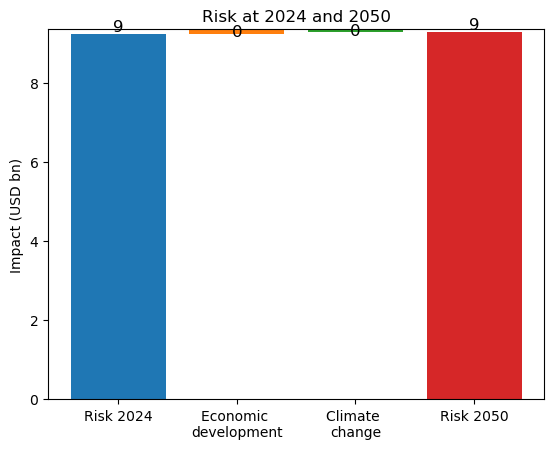

In [13]:
# Example HW
# Set present Entity
entity_present = Entity.from_excel(
    DATA_ENTITIES_DIR / "2_entity_TODAY_EGYPT_HW_USD_1.xlsx"
)
# Set exposure ref year
entity_present.exposures.ref_year = 2024
entity_present.check()

# Set future Entity
entity_future = deepcopy(entity_present)
entity_future.exposures.ref_year = 2050
growth = 0.04
entity_future.exposures.gdf["value"] = entity_future.exposures.gdf.value.values * (1 + growth) ** (
    entity_future.exposures.ref_year - entity_present.exposures.ref_year
)
entity_future.check()

# Set present Hazard
hazard_present = Hazard.from_raster(
    DATA_HAZARDS_DIR / "hazard_HW_EGY_historical.tif",
    attrs={
        # "frequency": np.array([0.5, 0.2, 0.1, 0.04]),
        'frequency': np.array([0.2, 0.04, 0.5, 0.1]),
        "event_id": np.array([1, 2, 3, 4]),
        "units": "m",
    },
    haz_type="HW",
    band=[1, 2, 3, 4],
)
hazard_present.units = "m"
hazard_present.centroids.set_geometry_points()
hazard_present.intensity_thres = 0
hazard_present.check()

# Set future hazard
hazard_future = Hazard.from_raster(
    DATA_HAZARDS_DIR / "hazard_HW_EGY_rcp45.tif",
    attrs={
        "frequency": np.array([0.5, 0.2, 0.1, 0.04]),
        "event_id": np.array([1, 2, 3, 4]),
        "units": "m",
    },
    haz_type="HW",
    band=[1, 2, 3, 4],
)
hazard_future.units = "m"
hazard_future.centroids.set_geometry_points()
hazard_future.intensity_thres = 0
hazard_future.check()

# Calculate impact
impact_present = ImpactCalc(
    entity_present.exposures, entity_present.impact_funcs, hazard_present
).impact()
impact_future = ImpactCalc(
    entity_future.exposures, entity_future.impact_funcs, hazard_future
).impact()

# Calculate cost-benefit
cost_benefit = CostBenefit()
cost_benefit.calc(
    hazard=hazard_present,
    entity=entity_present,
    haz_future=hazard_future,
    ent_future=entity_future,
    risk_func=risk_aai_agg,
    save_imp=True,
)

# Plot cost benefit waterfall
axis = cost_benefit.plot_waterfall(
    hazard_present,
    entity_present,
    hazard_future,
    entity_future,
    risk_func=risk_aai_agg,
)

In [48]:
25529996+32512000+160062+7983163

66185680

66185221

In [37]:
11192055+14211000+65908+3287185

28756148

In [12]:
mat = impact_future.imp_mat.toarray()
df = pd.DataFrame(mat)
df.to_excel('output.xlsx', index=False)
# scipy.sparse._csr.csr_matrix

Risk at 2024: 4.429e+06
Risk with development at 2050: 4.447e+06
Risk with development and climate change at 2050: 5.051e+06


<AxesSubplot:title={'center':'Risk at 2024 and 2050'}, ylabel='Impact (People m)'>

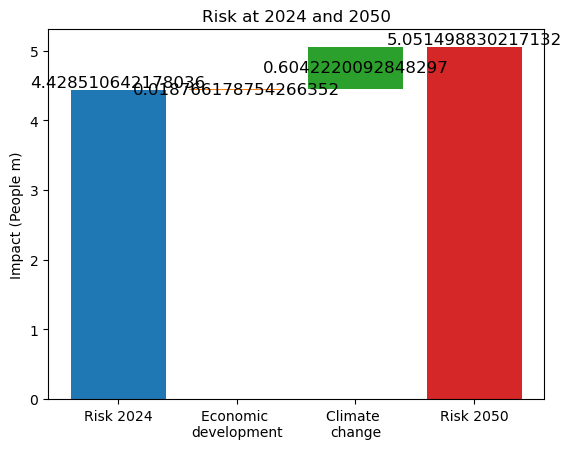

In [27]:
def _norm_values(value):
    norm_fact = 1.
    norm_name = ''
    if value / 1.0e9 > 1:
        norm_fact = 1.0e9
        norm_name = 'bn'
    elif value / 1.0e6 > 1:
        norm_fact = 1.0e6
        norm_name = 'm'
    elif value / 1.0e3 > 1:
        norm_fact = 1.0e3
        norm_name = 'k'
    return norm_fact, norm_name


def test():
    axis=None
    if entity_future.exposures.ref_year == entity_present.exposures.ref_year:
        raise ValueError('Same reference years for future and present entities.')
    present_year = entity_present.exposures.ref_year
    future_year = entity_future.exposures.ref_year

    imp = ImpactCalc(entity_present.exposures, entity_present.impact_funcs, hazard_present)\
            .impact(assign_centroids=hazard_present.centr_exp_col not in entity_present.exposures.gdf)
    curr_risk = risk_aai_agg(imp)

    imp = ImpactCalc(entity_future.exposures, entity_future.impact_funcs, hazard_future)\
            .impact(assign_centroids=hazard_present.centr_exp_col not in entity_future.exposures.gdf)
    fut_risk = risk_aai_agg(imp)

    if not axis:
        _, axis = plt.subplots(1, 1)
    norm_fact, norm_name = _norm_values(curr_risk)

    # current situation
    print('Risk at {:d}: {:.3e}'.format(present_year, curr_risk))

    # changing future
    # socio-economic dev
    imp = ImpactCalc(entity_future.exposures, entity_future.impact_funcs, hazard_present)\
            .impact(assign_centroids=False)
    risk_dev = risk_aai_agg(imp)
    print('Risk with development at {:d}: {:.3e}'.format(future_year, risk_dev))

    # socioecon + cc
    print('Risk with development and climate change at {:d}: {:.3e}'.
                format(future_year, fut_risk))

    axis.bar(1, curr_risk / norm_fact)
    axis.text(1, curr_risk / norm_fact, str(int(round(curr_risk / norm_fact))),
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=12, color='k')
    axis.bar(2, height=(risk_dev - curr_risk) / norm_fact,
                bottom=curr_risk / norm_fact)
    axis.text(2, curr_risk / norm_fact + (risk_dev - curr_risk) / norm_fact / 2,
                str(int(round((risk_dev - curr_risk) / norm_fact))),
                horizontalalignment='center', verticalalignment='center', fontsize=12, color='k')
    axis.bar(3, height=(fut_risk - risk_dev) / norm_fact,
                bottom=risk_dev / norm_fact)
    axis.text(3, risk_dev / norm_fact + (fut_risk - risk_dev) / norm_fact / 2,
                str(int(round((fut_risk - risk_dev) / norm_fact))),
                horizontalalignment='center', verticalalignment='center', fontsize=12,
                color='k')
    axis.bar(4, height=fut_risk / norm_fact)
    axis.text(4, fut_risk / norm_fact, str(int(round(fut_risk / norm_fact))),
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=12, color='k')

    axis.set_xticks(np.arange(4) + 1)
    axis.set_xticklabels(['Risk ' + str(present_year),
                            'Economic \ndevelopment',
                            'Climate \nchange',
                            'Risk ' + str(future_year)])
    axis.set_ylabel('Impact (' + imp.unit + ' ' + norm_name + ')')
    axis.set_title('Risk at {:d} and {:d}'.format(present_year, future_year))
    return axis

test()

In [17]:
risk_aai_agg(impact_present)

4428510.642178036

In [14]:
risk_aai_agg(impact_future)

5051498.830217132

In [18]:
entity_present.exposures.gdf

,category_id,latitude,longitude,value,value_unit,deductible,cover,impf_,region_id,centr_FL
0,301,21.762500,33.520833,1.9,People,0,1.9,301,NaN,65860
1,301,21.762500,33.770833,0.2,People,0,0.2,301,NaN,65866
2,301,21.804167,33.479167,0.6,People,0,0.6,301,NaN,65582
3,301,21.845833,33.395833,1.9,People,0,1.9,301,NaN,65303
4,301,21.845833,34.020833,0.4,People,0,0.4,301,NaN,65318
...,...,...,...,...,...,...,...,...,...,...
4774,301,31.595833,31.145833,74.9,People,0,74.9,301,NaN,431
4775,301,31.595833,31.187500,24.3,People,0,24.3,301,NaN,432
4776,301,31.637500,25.104167,5.7,People,0,5.7,301,NaN,9
4777,301,31.637500,25.895833,0.2,People,0,0.2,301,NaN,28


In [41]:
entity_future.exposures.gdf

,category_id,latitude,longitude,value,value_unit,deductible,cover,impf_,region_id,centr_FL
0,301,21.762500,33.520833,4.035914,People,0,1.9,301,NaN,65860
1,301,21.762500,33.770833,0.424833,People,0,0.2,301,NaN,65866
2,301,21.804167,33.479167,1.274499,People,0,0.6,301,NaN,65582
3,301,21.845833,33.395833,4.035914,People,0,1.9,301,NaN,65303
4,301,21.845833,34.020833,0.849666,People,0,0.4,301,NaN,65318
...,...,...,...,...,...,...,...,...,...,...
4774,301,31.595833,31.145833,159.099963,People,0,74.9,301,NaN,431
4775,301,31.595833,31.187500,51.617211,People,0,24.3,301,NaN,432
4776,301,31.637500,25.104167,12.107741,People,0,5.7,301,NaN,9
4777,301,31.637500,25.895833,0.424833,People,0,0.2,301,NaN,28


In [27]:
from shapely.geometry import Point
return_periods = (10,)

def test():
    try:
        # country_iso3 = base_handler.get_iso3_country_code(country_name)
        admin_gdf = base_handler.get_admin_data('THA', 2)
        # return admin_gdf
        coords = np.array(hazard_future.centroids.coord)
        local_exceedance_inten = hazard_future.local_exceedance_inten(return_periods)
        local_exceedance_inten = pd.DataFrame(local_exceedance_inten).T
        data = np.column_stack((coords, local_exceedance_inten))
        columns = ["latitude", "longitude"] + [f"rp{rp}" for rp in return_periods]

        hazard_df = pd.DataFrame(data, columns=columns)
        geometry = [Point(xy) for xy in zip(hazard_df["longitude"], hazard_df["latitude"])]
        hazard_gdf = gpd.GeoDataFrame(hazard_df, geometry=geometry, crs="EPSG:4326")
        hazard_gdf = hazard_gdf[
            (hazard_gdf[[f"rp{rp}" for rp in return_periods]] != 0).any(axis=1)
        ]

        # Spatial join with administrative areas
        joined_gdf = gpd.sjoin(hazard_gdf, admin_gdf, how="left", predicate="within")
        # Remove points outside of the country
        # TODO: Test if this needs to be refined
        joined_gdf = joined_gdf[~joined_gdf["country"].isna()]
        joined_gdf = joined_gdf.drop(columns=["latitude", "longitude", "index_right"])
        joined_gdf = joined_gdf.reset_index(drop=True)
        return joined_gdf

        radius = hazard_handler.get_circle_radius(hazard_future.haz_type)
        # Convert to GeoJSON for this layer and add to all_layers_geojson
        hazard_geojson = joined_gdf.__geo_interface__
        hazard_geojson["_metadata"] = {
            "unit": hazard_future.units,
            "title": f"Hazard ({hazard_future.units})",
            "radius": radius,
        }

        print(hazard_geojson)

        # Save the combined GeoJSON file
        map_data_filepath = DATA_TEMP_DIR / "hazards_geodata.json"
        with open(map_data_filepath, "w", encoding="utf-8") as f:
            json.dump(hazard_geojson, f)
    except Exception as exception:
        print("error", f"An unexpected error occurred. More info: {exception}")

test()

,rp10,geometry,name,id,country
0,7.431053,POINT (99.89583 20.43750),Mae Sai,78962969B77197362168245,THA
1,7.431053,POINT (99.93750 20.43750),Mae Sai,78962969B77197362168245,THA
2,7.431053,POINT (99.97917 20.43750),Mae Sai,78962969B77197362168245,THA
3,2.410039,POINT (99.89583 20.39583),Mae Sai,78962969B77197362168245,THA
4,4.125377,POINT (99.93750 20.39583),Mae Sai,78962969B77197362168245,THA
...,...,...,...,...,...
7689,4.471317,POINT (101.60417 6.02083),Chanae,78962969B80683407525077,THA
7690,4.471317,POINT (101.64583 6.02083),Chanae,78962969B80683407525077,THA
7691,4.471317,POINT (101.68750 6.02083),Chanae,78962969B80683407525077,THA
7692,2.900995,POINT (101.68750 5.97917),Sukhirin,78962969B93251950342274,THA


In [42]:
hazard_future.centroids.set_geometry_points()

In [43]:
hazard_future.centroids.coord

array([[ 20.4375    ,  97.35416667],
       [ 20.4375    ,  97.39583333],
       [ 20.4375    ,  97.4375    ],
       ...,
       [  5.64583333, 105.52083333],
       [  5.64583333, 105.5625    ],
       [  5.64583333, 105.60416667]])

(<GeoAxesSubplot:title={'center':'Return period: 15 years'}>,
 array([[0., 0., 0., ..., 0., 0., 0.]]))

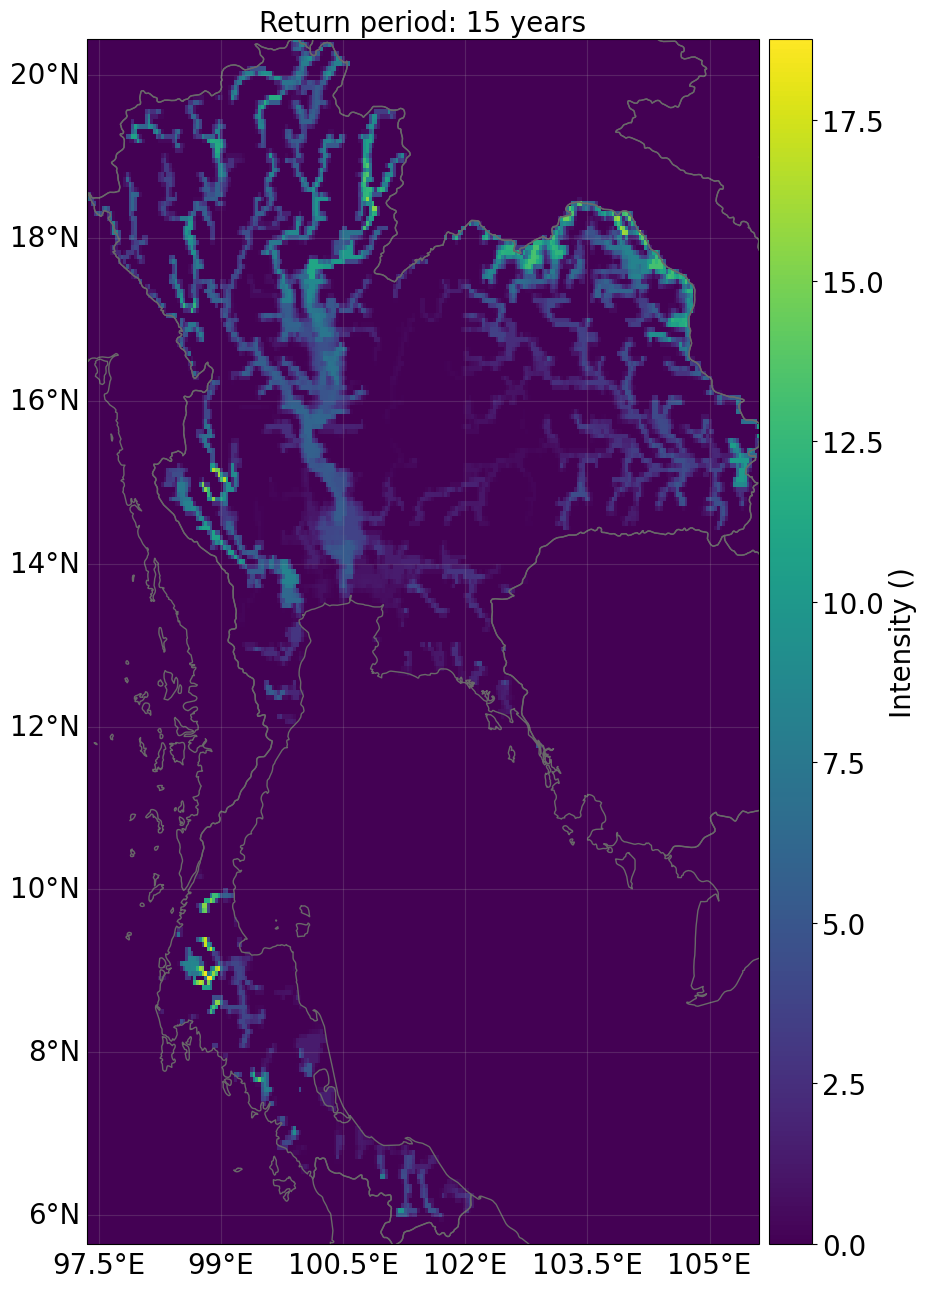

In [9]:
hazard_future.plot_rp_intensity((15,))

In [ ]:
# List DataTypeInfos
data_type_infos = client.list_data_type_infos()
exposure_data_types = [
    data_type_info.data_type
    for data_type_info in data_type_infos
    if data_type_info.data_type_group == "exposures"
]
hazard_data_types = [
    data_type_info.data_type
    for data_type_info in data_type_infos
    if data_type_info.data_type_group == "hazard"
]

print(
    f"Available Exposure data types in CLIMADA API for all countries:\n{exposure_data_types}")
print(
    f"Available Hazard data types in CLIMADA API for all countries:\n{hazard_data_types}")

In [ ]:
# Available country Exposures and Hazard data types
dataset_infos = client.list_dataset_infos(
    properties={
        "country_name": country_name,
    }
)

exposure_data_types = list(
    set(
        [
            dataset_info.data_type.data_type
            for dataset_info in dataset_infos
            if dataset_info.data_type.data_type_group == "exposures"
        ]
    )
)
hazard_data_types = list(
    set(
        [
            dataset_info.data_type.data_type
            for dataset_info in dataset_infos
            if dataset_info.data_type.data_type_group == "hazard"
        ]
    )
)

print(
    f"Available Exposure data types in CLIMADA API for {country_name}: {exposure_data_types}")
print(
    f"Available Hazard data types in CLIMADA API for {country_name}: {hazard_data_types}")

In [ ]:
# Available climate scenarios and time horizons for specific hazard type in countries Thailand and Egypt
if hazard_type == "river_flood" or "wildfire":
    available_scenarios = list(
        set(
            [
                dataset_info.properties["climate_scenario"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
    available_time_horizons = list(
        set(
            [
                dataset_info.properties["year_range"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
if hazard_type == "tropical_cyclone":
    available_scenarios = list(
        set(
            [
                dataset_info.properties["climate_scenario"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
    available_time_horizons = list(
        set(
            [
                dataset_info.properties.get("ref_year")
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
if hazard_type == "earthquake":
    available_scenarios = []
    available_time_horizons = []
if hazard_type == "flood":
    available_scenarios = []
    available_time_horizons = list(
        set(
            [
                dataset_info.properties["year_range"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )

print(
    f"Available climate scenarios for hazard type {hazard_type} in country {country_name}: {available_scenarios}"
)
print(
    f"Available time horizons for hazard type {hazard_type} in country {country_name}: {available_time_horizons}"
)

In [ ]:
# Available country Hazard DatasetInfos
hazard_dataset_infos = client.list_dataset_infos(
    properties={
        "data_type": "river_flood",
        "country_name": "Thailand",
        "climate_scenario": "rcp26",
        "year_range": "2030_2050",
    }
)
hazard_dataset_infos

In [ ]:
# Get Exposure
# Available Exposures: ['litpop']
exposure_present = exposure_handler.get_exposure(country_name)
if annual_growth > 1:
    exposure_future = exposure_handler.get_growth_exposure(
        exposure_present, annual_growth, 2040)

In [ ]:
# Get Hazard
# Available Hazards: ['river_flood', 'tropical_cyclone', 'wildfire', 'flood', 'earthquake']
hazard_present = hazard_handler.get_hazard(
    hazard_type,
    "historical",
    "1980_2000",
    country_name,
)

if scenario != "historical":
    hazard_future = hazard_handler.get_hazard(
        hazard_type,
        scenario,
        time_horizon,
        country_name,
    )

In [ ]:
# Get Impact
impact_function_set = impact_handler.calculate_impact_function_set(hazard_present)
impact_present = impact_handler.calculate_impact(exposure_present, hazard_present, impact_function_set)

if scenario != "historical":
    if annual_growth > 1:
        impact_future = impact_handler.calculate_impact(
            exposure_future, hazard_future, impact_function_set)
    impact_future = impact_handler.calculate_impact(
        exposure_present, hazard_future, impact_function_set)

In [ ]:
measure_set = costben_handler.get_measure_set_from_excel('RF')
discount_rates = costben_handler.get_discount_rates_from_excel()

In [ ]:
import pandas as pd
import sqlite3

class DataFrameSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def save_dataframe(self, df, table_name):
        """
        Save a DataFrame to the SQLite database.
        
        :param df: DataFrame to save.
        :param table_name: Name of the table to save the DataFrame to.
        """
        with sqlite3.connect(self.db_path) as conn:
            df.to_sql(table_name, conn, if_exists='replace', index=False)
            print(f"DataFrame saved to {table_name} table.")

    def read_dataframe(self, table_name):
        """
        Read a DataFrame from the SQLite database.
        
        :param table_name: Name of the table to read the DataFrame from.
        :return: DataFrame read from the database.
        """
        with sqlite3.connect(self.db_path) as conn:
            df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
        return df

# Example usage
db_path = 'my_data.db'  # Path to your SQLite database file
df_sqlite = DataFrameSQLite(db_path)

# Assuming you have a DataFrame `df` to save
df_sqlite.save_dataframe(exp_gdf, 'exposure')

# To read the saved DataFrame from the database
df_read = df_sqlite.read_dataframe('exposure')
print(df_read)


In [ ]:
import pandas as pd
import sqlite3


class ExcelToSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def read_excel_to_df(self, excel_path, sheet_name):
        """Reads a specified sheet from an Excel file into a DataFrame."""
        return pd.read_excel(excel_path, sheet_name=sheet_name)

    def adjust_df_columns(self, df, columns_to_keep=None):
        """Adjusts DataFrame columns based on the provided list. If None, keeps all columns."""
        if columns_to_keep is not None:
            df = df[columns_to_keep]
        return df

    def save_df_to_sqlite(self, df, table_name):
        """Saves a DataFrame to an SQLite table, appending data if the table already exists."""
        with sqlite3.connect(self.db_path) as conn:
            df.to_sql(table_name, conn, if_exists="append", index=False)

    def read_table(self, table_name):
        """Reads a table from SQLite database into a DataFrame."""
        with sqlite3.connect(self.db_path) as conn:
            return pd.read_sql(f"SELECT * FROM {table_name}", conn)


# Example usage
db_path = "climadera.db"  # Path to your SQLite database file
excel_path = DATA_ENTITIES_DIR / "3_entity_TODAY_THAI_D_USD_1_modified.xlsx"  # Path to your Excel file
excel_to_sqlite = ExcelToSQLite(db_path)

# Define the sheets and corresponding table names
sheets_tables = {
    "assets": "exposures",
    "impact_functions": "impact_functions",
    "measures": "measures",
    "discount": "discount_rates",
    "names": "names",
}

# Iterate over sheets and tables, read, adjust (if needed), and save to SQLite
for sheet, table in sheets_tables.items():
    df = excel_to_sqlite.read_excel_to_df(excel_path, sheet)

    # Here you can define which columns to keep for each table if needed, e.g.:
    # if table == 'exposures':
    #     columns_to_keep = ['Column1', 'Column2']
    #     df = excel_to_sqlite.adjust_df_columns(df, columns_to_keep)
    # else:
    #     df = excel_to_sqlite.adjust_df_columns(df)

    excel_to_sqlite.save_df_to_sqlite(df, table)

In [ ]:
import pandas as pd
import sqlite3


class ExcelToSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def read_excel_and_save(self, excel_path, tabs_columns_mapping):
        """
        Read specified tabs from an Excel file and save them to SQLite database.

        :param excel_path: Path to the Excel file.
        :param tabs_columns_mapping: Dict mapping tab names to their columns adjustments.
        """
        with sqlite3.connect(self.db_path) as conn:
            for tab, columns in tabs_columns_mapping.items():
                df = pd.read_excel(excel_path, sheet_name=tab)

                # Adjust columns if specified
                if columns:
                    df = df[columns]

                df.to_sql(tab, conn, if_exists="append", index=False)
                print(f"Data from {tab} tab saved to {tab} table.")

    def read_table(self, table_name):
        """
        Read data from a specified table in the SQLite database.

        :param table_name: Name of the table to read data from.
        :return: DataFrame with the table data.
        """
        with sqlite3.connect(self.db_path) as conn:
            return pd.read_sql(f"SELECT * FROM {table_name}", conn)


# Example usage
db_path = "climadera.db"  # Path to your SQLite database file
excel_path = DATA_ENTITIES_DIR / "3_entity_TODAY_THAI_D_USD_1_modified.xlsx"  # Path to your Excel file
tabs_columns_mapping = {
    "assets": None,  # Specify columns as a list if you want to adjust them, or None to include all
    "impact_functions": None,
    "measures": None,
    "discount": None,
    "names": None,
}

excel_to_sqlite = ExcelToSQLite(db_path)
excel_to_sqlite.read_excel_and_save(excel_path, tabs_columns_mapping)

# Reading data from one of the tables
df_assets = excel_to_sqlite.read_table("assets")
print(df_assets)